# Regional Analysis (grid)

In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import time
#import seaborn as sns
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from dask.diagnostics import ProgressBar

In [2]:
#load datasets, in this analysis I used monthly datasets
prism_origin = xr.open_mfdataset('/home/chc-shrad/DATA/Atmopheric_forcings/PRISM/Monthly/ppt/netcdf/PRISM_ppt_stable_4kmM3_*.nc', concat_dim='time', combine='nested', chunks={'latitude':100, 'longitude':200})
chirps_origin = xr.open_mfdataset('/home/chc-data-out/products/CHIRPS-2.0/global_monthly/netcdf/*.nc', concat_dim='time', combine='nested', chunks={'latitude':100, 'longitude':200})

In [3]:
#slice CHIRPS dataset to ensure that it has the same time range as PRISM
chirps = chirps_origin.precip.sel(time = slice('1981-01-01', '2022-08-01'), latitude=slice(prism_origin.latitude.min(), prism_origin.latitude.max()), 
                                longitude=slice(prism_origin.longitude.min(), prism_origin.longitude.max()))

In [4]:
#PRISM uses the 15th day for each month and CHIRPS uses the first day for each month
#let them have the same time values
prism = prism_origin.precip.assign_coords(time = chirps.time)

In [5]:
#interpolation
prism = prism.interp_like(chirps)

In [14]:
# prism = prism.to_dataset(name = 'ppt') This is not needed

In [6]:
#filter to contain only the US states data
chirps = chirps.where(prism >= 0)

In [7]:
chirps_coarse = chirps.coarsen(latitude=10, longitude=10, boundary='trim').mean()
prism_coarse = prism.coarsen(latitude=10, longitude=10, boundary='trim').mean()

In [8]:
start_time = time.time()
chirps_coarse = chirps_coarse.load()
prism_coarse = prism_coarse.load()
elapsed_time = time.time() - start_time
print("Elapsed time: {:.2f} seconds".format(elapsed_time))

Elapsed time: 369.55 seconds


In [9]:
prism_coarse = prism_coarse.assign_coords(latitude = chirps_coarse.latitude)
prism_coarse = prism_coarse.assign_coords(longitude = chirps_coarse.longitude)

### Euclidean

In [22]:
# Defining a function to calculate euclidean distance
def calc_euclidean(grid_ts1, grid_ts2):
    if np.isnan(grid_ts1).sum()>0: # checking if there is any nan values if yes then assign nan to euclidean_distance
        euclidean_distance = np.nan
    else:
        euclidean_distance = euclidean(grid_ts1, grid_ts2) # calculating euclidean_distance for non nan time-series
    return euclidean_distance

In [23]:
# Using Dask to parallelize the computation, chunking latitude and longitude so in this case so parallel operation happens at 1 grid cell at a time
chirps_coarse = chirps_coarse.chunk({'time': -1, 'latitude': 10, 'longitude': 10})
prism_coarse = prism_coarse.chunk({'time': -1, 'latitude': 10, 'longitude': 10})

start_time = time.time()

# Apply the function to each grid cell of both xarrays
euclidean_distance_ar = xr.apply_ufunc(
    calc_euclidean,
    chirps_coarse,
    prism_coarse,
    input_core_dims=[['time'], ['time']],
    output_core_dims=[[]],
    vectorize=True,
    dask="parallelized", 
    output_dtypes=[prism_coarse.dtype],
)
euclidean_distance_ar = euclidean_distance_ar.compute()
elapsed_time = time.time() - start_time
print("Elapsed time: {:.2f} seconds".format(elapsed_time))

Elapsed time: 0.39 seconds


### DTW

In [10]:
# Defining a function to calculate DTW value
def calc_dtw(grid_ts1, grid_ts2):
    if np.isnan(grid_ts1).sum()>0: # checking if there is any nan values if yes then assign nan to euclidean_distance
        dtw = np.nan
    else:
        dtw = fastdtw(grid_ts1, grid_ts2)[0] # calculating euclidean_distance for non nan time-series
    return dtw

In [11]:
#DTW
# Using Dask to parallelize the computation, chunking latitude and longitude so in this case so parallel operation happens at 1 grid cell at a time
chirps_coarse = chirps_coarse.chunk({'time': -1, 'latitude': 10, 'longitude': 10})
prism_coarse = prism_coarse.chunk({'time': -1, 'latitude': 10, 'longitude': 10})

start_time = time.time()

# Apply the function to each grid cell of both xarrays
dtw_ar = xr.apply_ufunc(
    calc_dtw,
    chirps_coarse,
    prism_coarse,
    input_core_dims=[['time'], ['time']],
    output_core_dims=[[]],
    vectorize=True,
    dask="parallelized", 
    output_dtypes=[prism_coarse.dtype],
)
dtw_ar = dtw_ar.compute()
elapsed_time = time.time() - start_time
print("Elapsed time: {:.2f} seconds".format(elapsed_time))

Elapsed time: 335.93 seconds


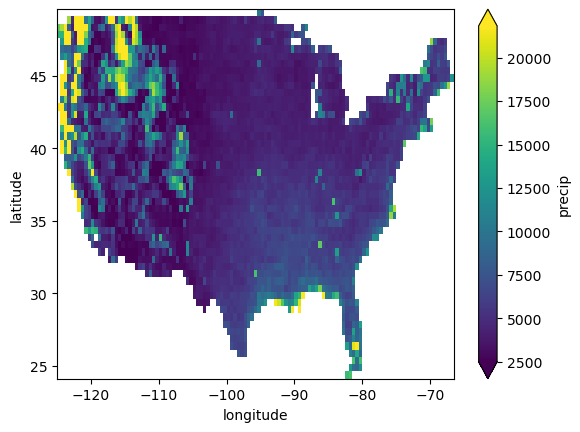

In [13]:
dtw_ar.plot(robust = True)

### Difference for each pixels each month

In [11]:
chirps_coarse = chirps_coarse.chunk({'time': -1, 'latitude': 10, 'longitude': 10})
prism_coarse = prism_coarse.chunk({'time': -1, 'latitude': 10, 'longitude': 10})

In [12]:
def calc_mon_diff(grid_ts1, grid_ts2):
    if np.isnan(grid_ts1).sum()>0: 
        diff = np.nan
    else:
        diff = grid_ts1 - grid_ts2 
    return diff

chirps_prism_mon_diff = xr.apply_ufunc(
    calc_mon_diff,
    chirps_coarse,
    prism_coarse,
    input_core_dims=[[], []],
    output_core_dims=[[]],
    vectorize=True,
    dask="parallelized", 
    output_dtypes=[chirps_coarse.dtype],
)
chirps_prism_mon_diff = chirps_prism_mon_diff.compute()

In [13]:
month_idxs=chirps_prism_mon_diff.groupby('time.month').groups

jan_idxs=month_idxs[1]

diff_jan=chirps_prism_mon_diff.isel(time=jan_idxs)

In [14]:
len(diff_jan)

Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


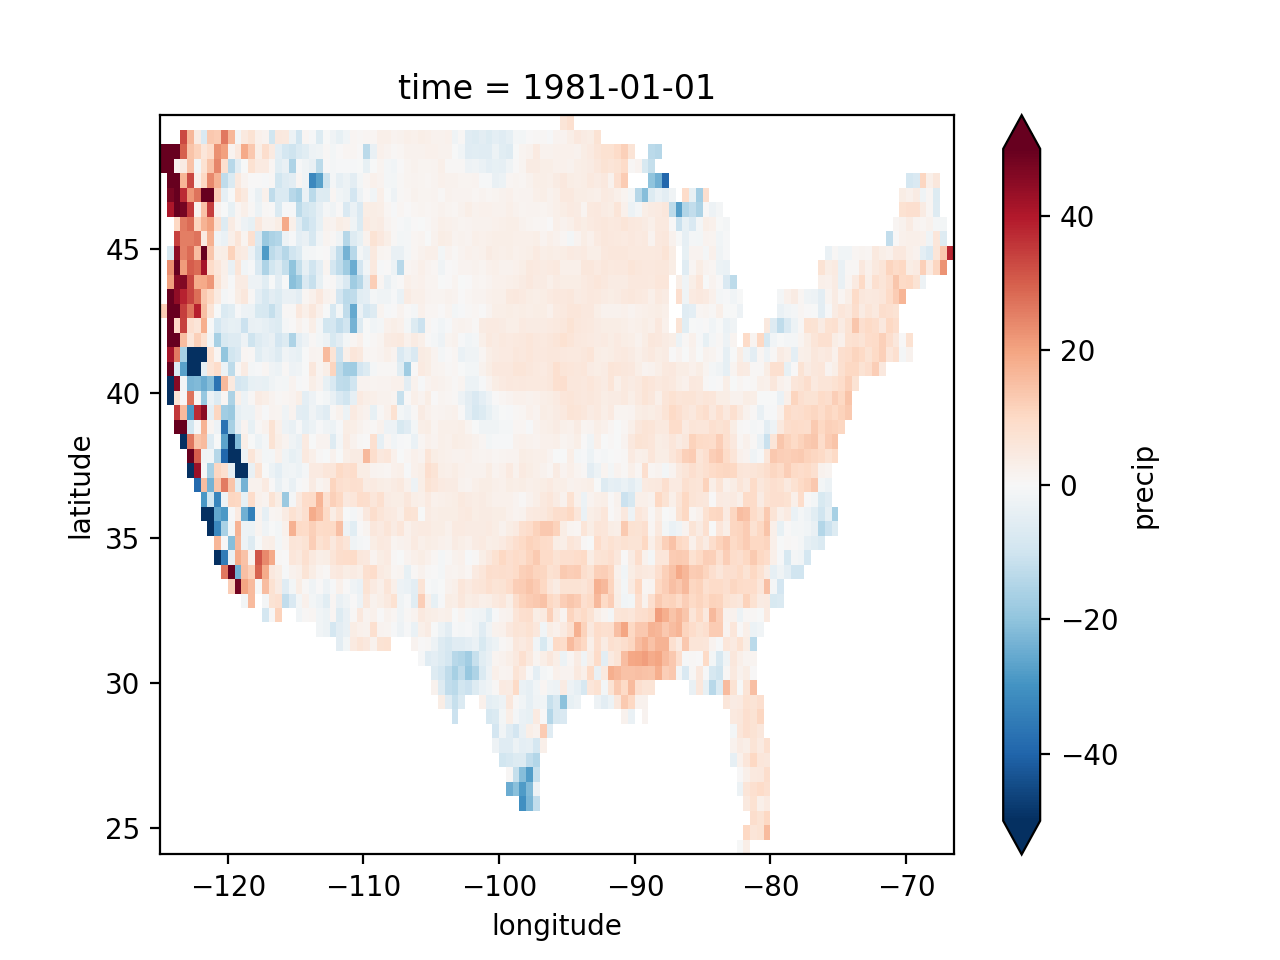

In [51]:
%matplotlib
chirps_prism_mon_diff[0,:,:].plot(robust = True, cmap = 'RdBu_r', vmin = -50, vmax = 50)
plt.show()

In [16]:
time, lat, lon = diff_jan.indexes.values()

In [17]:
fig, ax = plt.subplots()
ax.imshow(diff_jan[0,:,:],cmap = 'RdBu_r', vmin = -50, vmax = 50, origin="lower")

In [18]:
import matplotlib.animation as animation
fig, ax = plt.subplots()

artists = []
for i in range(42):
    container = ax.imshow(diff_jan[i,:,:],cmap = 'RdBu_r', vmin = -50, vmax = 50, origin="lower")
    artists.append(container)


ani = animation.ArtistAnimation(fig=fig, artists=artists, interval=100)
plt.show()

---

## Time Series Analysis

In [72]:
#get the mean precipitation over all pixels for the PRISM dataset
prism_ppt_mean = np.mean(prism_ppt.ppt, axis = 1)
prism_ppt_mean = np.mean(prism_ppt_mean, axis = 1)

In [91]:
#get the max precipitation over all pixels for the PRISM dataset
prism_ppt_max = np.max(abs(prism_ppt.ppt), axis = 1)
prism_ppt_max = np.max(abs(prism_ppt_max), axis = 1)

In [76]:
#get the mean precipitation over all pixels for the CHIRPS dataset
chirps_ppt_mean = np.mean(chirps_ppt.ppt, axis = 1)
chirps_ppt_mean = np.mean(chirps_ppt_mean, axis = 1)

In [93]:
#get the max precipitation over all pixels for the CHIRPS dataset
chirps_ppt_max = np.max(abs(chirps_ppt.ppt), axis = 1)
chirps_ppt_max = np.max(abs(chirps_ppt_max), axis = 1)

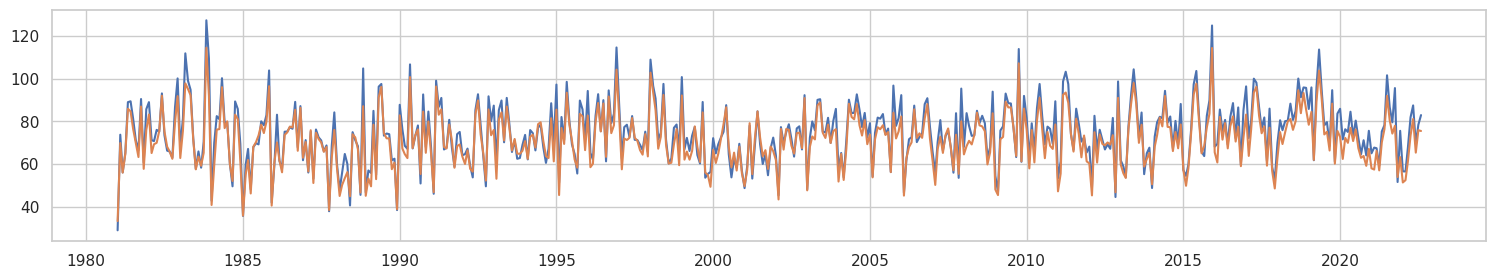

In [89]:
sns.set_theme(style = 'whitegrid')
fig = plt.gcf()
fig.set_size_inches(18.5, 3, forward = True)
plt.plot(prism_ppt_mean.time, prism_ppt_mean)
plt.plot(chirps_ppt_mean.time, chirps_ppt_mean)
fig.savefig('month_timeseries_mean.png', dpi=100)

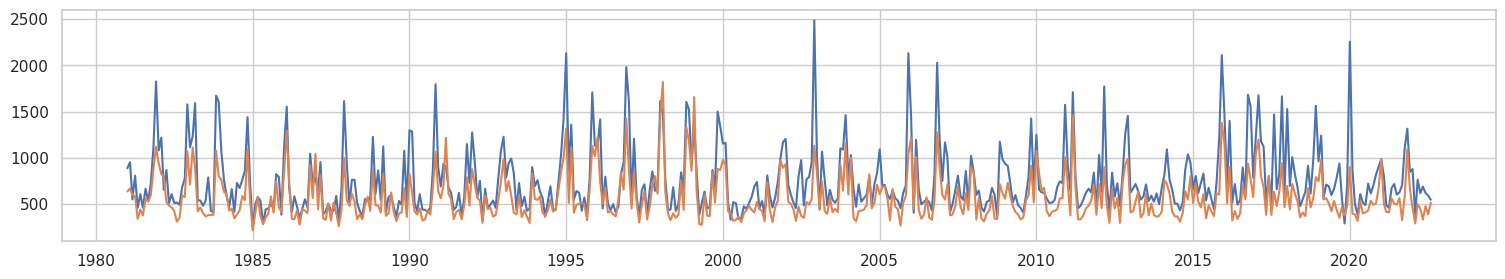

In [95]:
sns.set_theme(style = 'whitegrid')
fig = plt.gcf()
fig.set_size_inches(18.5, 3, forward = True)
plt.plot(prism_ppt_max.time, prism_ppt_max)
plt.plot(chirps_ppt_max.time, chirps_ppt_max)
fig.savefig('month_timeseries_max.png', dpi=100)

---

## Draft

In [11]:

diff = chirps - prism

In [14]:
diffmean = np.mean(diff.ppt, axis = [1,2])
diffmean = diffmean.compute()

In [46]:
diffmax = np.max(abs(diff.ppt), axis = [1,2])
diffmax = diffmax.compute()

In [50]:
diffmean.to_netcdf('diffmean')

In [51]:
diffmax.to_netcdf('diffmax')

In [15]:
diffmean

<xarray.DataArray 'ppt' (time: 15218)>
array([-0.03895941, -0.00550132, -0.05759273, ...,  1.0801806 ,
        0.18014388, -1.2080214 ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2022-08-31

In [41]:
diffsum_month = diffmean.resample(time='m').sum(dim='time', skipna=False)

In [48]:
diffsum_month_max = diffmax.resample(time='m').sum(dim='time', skipna=False)

In [20]:
import seaborn as sns

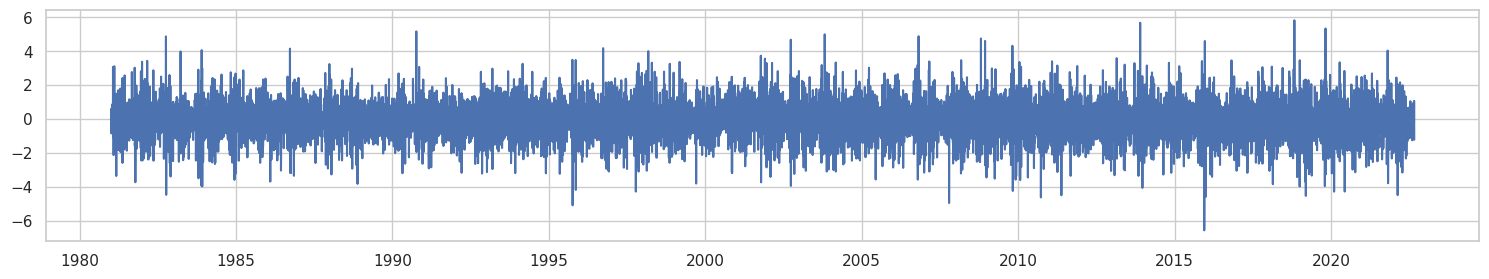

In [30]:
sns.set_theme(style = 'whitegrid')
fig = plt.gcf()
fig.set_size_inches(18.5, 3, forward = True)
plt.plot(diffmean.time, diffmean)
fig.savefig('diffmean.png', dpi=100)

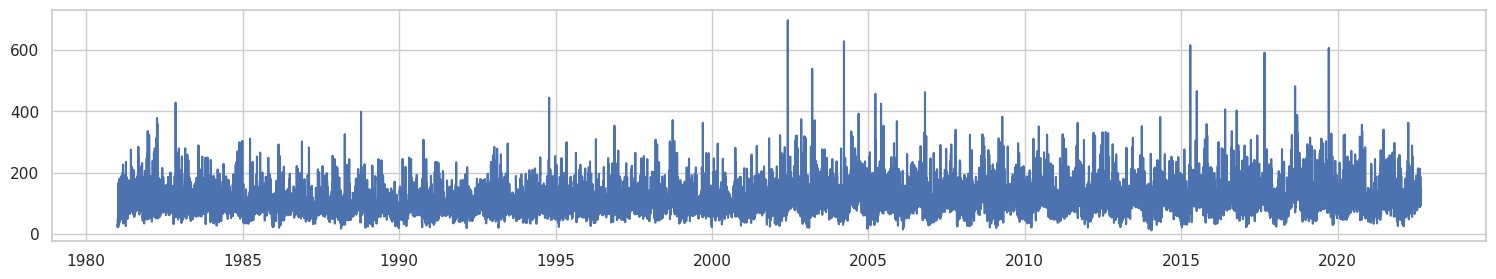

In [47]:
fig = plt.gcf()
fig.set_size_inches(18.5, 3, forward = True)
plt.plot(diffmax.time, diffmax)
fig.savefig('diffmax.png', dpi=100)

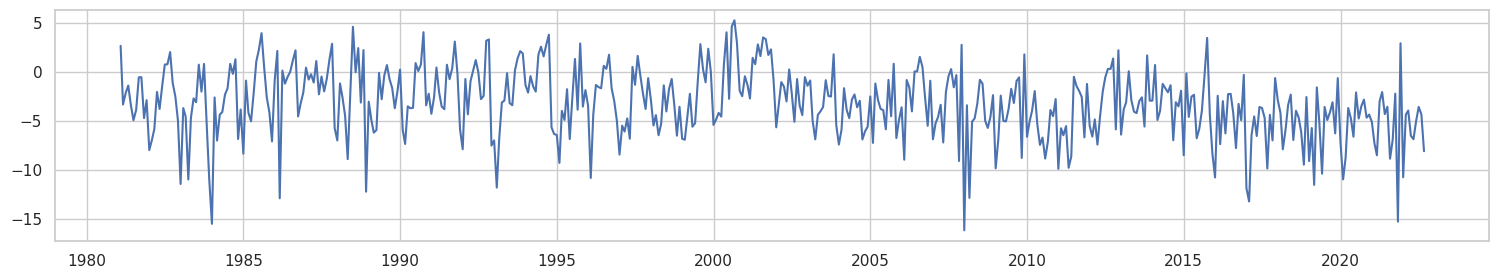

In [43]:
sns.set_theme(style = 'whitegrid')
fig = plt.gcf()
fig.set_size_inches(18.5, 3, forward = True)
plt.plot(diffsum_month.time, diffsum_month)
fig.savefig('diffsum_month.png', dpi=100)

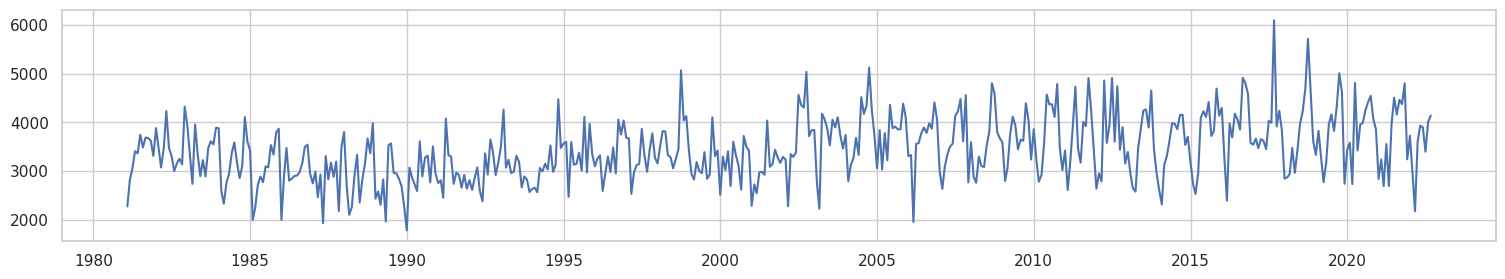

In [49]:
fig = plt.gcf()
fig.set_size_inches(18.5, 3, forward = True)
plt.plot(diffsum_month_max.time, diffsum_month_max)
fig.savefig('diffsum_month_max.png', dpi=100)

---

In [16]:
def compute_metrics(dataset1, dataset2, fill_value=0):
    # Ensure both datasets have the same dimensions
    assert dataset1.dims == dataset2.dims, "Datasets must have the same dimensions"

    # Get dimensions of the datasets
    time_size, lat_size, lon_size = dataset1.sizes['time'], dataset1.sizes['latitude'], dataset1.sizes['longitude']

    # Initialize empty arrays for storing Euclidean distance and DTW values
    euclidean_distances = np.zeros((lat_size, lon_size))
    dtw_values = np.zeros((lat_size, lon_size))

    # Iterate over each pixel
    for lat in range(lat_size):
        for lon in range(lon_size):
            # Extract time series data for the current pixel from both datasets
            ts1 = dataset1.isel(latitude=lat, longitude=lon).values
            ts2 = dataset2.isel(latitude=lat, longitude=lon).values

            # Replace missing values with fill_value
            ts1 = np.nan_to_num(ts1, nan=fill_value)
            ts2 = np.nan_to_num(ts2, nan=fill_value)

            # Compute Euclidean distance and DTW value
            euclidean_distances[lat, lon] = euclidean(ts1, ts2)
            dtw_values[lat, lon] = fastdtw(ts1, ts2)[0]

    # Create Xarray datasets for the output
    euclidean_ds = xr.Dataset(
        {"euclidean_distance": (("latitude", "longitude"), euclidean_distances)},
        coords={"latitude": dataset1["latitude"], "longitude": dataset1["longitude"]}
    )

    dtw_ds = xr.Dataset(
        {"dtw_value": (("latitude", "longitude"), dtw_values)},
        coords={"latitude": dataset1["latitude"], "longitude": dataset1["longitude"]}
    )

    return euclidean_ds, dtw_ds

In [ ]:
euclidean_ds, dtw_ds = compute_metrics(chirps.ppt, prism.ppt)

In [27]:
cd /home/chc-shrad/DATA/IMERG/

/home/chc-shrad/DATA/IMERG


In [30]:
IMERG = xr.open_mfdataset("/home/chc-shrad/DATA/IMERG/3B*.nc4.nc")

ValueError: did not find a match in any of xarray's currently installed IO backends ['netcdf4', 'h5netcdf', 'scipy', 'zarr']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
http://xarray.pydata.org/en/stable/getting-started-guide/installing.html
http://xarray.pydata.org/en/stable/user-guide/io.html